# Project 8 Frequency studies

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c,e,hbar,k,m_e,e,pi,epsilon_0

In [2]:
# Constants
m_e_eV = m_e*c**2/e
E_endp_eV = 18600
E_endp = E_endp_eV * e

out_dir = './output/'

In [3]:
# definitions
def cres(theta, kin_e, B):
    f_0 = e*B / (2*pi*m_e)
    gamma = 1 + kin_e / m_e_eV
    f = f_0/gamma
    beta2 = 1 - 1/gamma**2
    num = 2*pi*e**2*f_0**2*np.sin(theta)**2*beta2*gamma**2
    denum = 3*epsilon_0*c
    power = num/denum
    return  power, f

# Make a spectrogram for an electron at the end point
def get_time_series(rot_steps,
                    time = 1,             # seconds, should be ms
                    max_rot = 1e12,       # rotations, should be 1e6
                    E_kin_e=E_endp_eV, 
                    theta=pi/2, 
                    tesla=1):
    t_arr = []
    r_arr = []
    f_arr = []
    E_arr = []
    P_arr = []

    t = 0
    r = 0
    E = E_kin_e

    while t < time and r < max_rot:
        power, f = cres(theta, E, tesla)
        dt = rot_steps/f
        t += dt
        r += rot_steps
        E -= power*dt/e
        r_arr.append(r)
        t_arr.append(t)
        f_arr.append(f)
        E_arr.append(E)
        P_arr.append(power)
    
    return np.array(r_arr), np.array(t_arr), np.array(f_arr), np.array(E_arr), np.array(P_arr)


In [4]:
# variabless
B = 1 
kin_e = E_endp_eV
orbits = 1e6
theta = pi/2

# What is the power radiated by an electron with baseline parameters:
cres(pi/2, E_endp_eV, 1)[0]

1.1763834382516466e-15

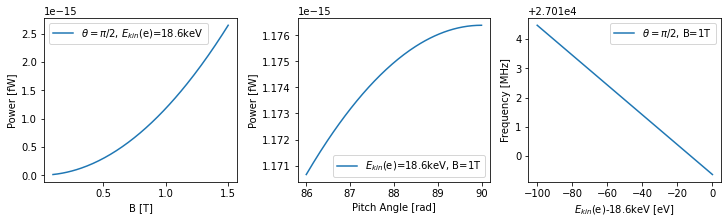

In [5]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(10,3))

# Vary B
B = np.linspace(0.1,1.5,150)
y_data = cres(pi/2, E_endp_eV, B)[0]
ax[0].plot(B,y_data, label = r'$\theta=\pi/2$, $E_{kin}$(e)=18.6keV')
ax[0].set_xlabel('B [T]')

# Vary pitch angle
pitch_angle = np.linspace(86*pi/180,pi/2,150)
y_data = cres(pitch_angle, E_endp_eV, 1)[0]
ax[1].plot(pitch_angle*180/pi,y_data, label = r'$E_{kin}$(e)=18.6keV, B=1T')
ax[1].set_xlabel('Pitch Angle [rad]')

# Vary electron energy
e_kin_E = np.linspace(E_endp_eV-100,E_endp_eV,150)
y_data = cres(pi/2, e_kin_E, 1)[1]
ax[2].plot(e_kin_E-E_endp_eV,y_data/1e6, label = r'$\theta=\pi/2$, B=1T')
ax[2].set_xlabel(r'$E_{kin}$(e)-18.6keV [eV]')

[ax_i.set_ylabel('Power [fW]') for ax_i in ax]
[ax_i.legend() for ax_i in ax]
ax[2].set_ylabel('Frequency [MHz]')

plt.savefig(out_dir + 'power_dep.pdf')

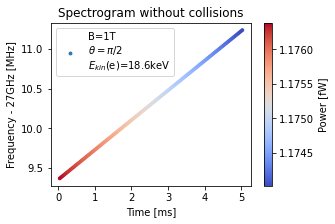

In [6]:
fig, ax = plt.subplots(figsize=(4.5,3))

r_arr, t_arr, f_arr, E_arr, P_arr = get_time_series(1e6, time=5e-3,)
#scaled_z = (P_arr - P_arr.min()) / P_arr.ptp()

sc = ax.scatter(t_arr/1e-3, f_arr/1e6 - 27e3, s=8, c=P_arr/1e-15, cmap = plt.cm.coolwarm, label='B=1T\n'+ r'$\theta=\pi/2$'+'\n'+r'$E_{kin}$(e)=18.6keV')
ax.set_ylabel('Frequency - 27GHz [MHz]')
ax.set_xlabel('Time [ms]')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Power [fW]')
ax.legend(loc='upper left')
ax.set_title('Spectrogram without collisions')
fig.savefig(out_dir + 'spectrogram.pdf')


In [7]:
teslas = np.linspace(0.1,1.5,15)
delta_f = []
f_min = []
delta_f_rot = []

print('Difference in frequency for endpoint electron after 5ms or 1e6 rotations') 
for tesla in teslas:
    _, _, f_arr, _, _ = get_time_series(1e6,time = 5e-3,tesla=tesla)   
    delta_f.append(f_arr.ptp()/1e6)
    f_min.append(f_arr.min()/1e9)

    _, _, f_arr, _, _ = get_time_series(1e4,max_rot= 1e6,tesla=tesla)    
    delta_f_rot.append(f_arr.ptp()/1e6)

    print('B: {:.1f}T \tf: {:.2f}GHz \tdelta_f (5ms): {:.2f}MHz \tdelta_f (1e6 rotations): {:.3f}MHz'.format(tesla, 
                              f_min[-1], 
                              delta_f[-1],
                              delta_f_rot[-1]))


Difference in frequency for endpoint electron after 5ms or 1e6 rotations
B: 0.1T 	f: 2.70GHz 	delta_f (5ms): 0.00MHz 	delta_f (1e6 rotations): 0.000MHz
B: 0.2T 	f: 5.40GHz 	delta_f (5ms): 0.01MHz 	delta_f (1e6 rotations): 0.001MHz
B: 0.3T 	f: 8.10GHz 	delta_f (5ms): 0.05MHz 	delta_f (1e6 rotations): 0.001MHz
B: 0.4T 	f: 10.80GHz 	delta_f (5ms): 0.12MHz 	delta_f (1e6 rotations): 0.002MHz
B: 0.5T 	f: 13.50GHz 	delta_f (5ms): 0.23MHz 	delta_f (1e6 rotations): 0.003MHz
B: 0.6T 	f: 16.21GHz 	delta_f (5ms): 0.40MHz 	delta_f (1e6 rotations): 0.005MHz
B: 0.7T 	f: 18.91GHz 	delta_f (5ms): 0.64MHz 	delta_f (1e6 rotations): 0.007MHz
B: 0.8T 	f: 21.61GHz 	delta_f (5ms): 0.96MHz 	delta_f (1e6 rotations): 0.009MHz
B: 0.9T 	f: 24.31GHz 	delta_f (5ms): 1.36MHz 	delta_f (1e6 rotations): 0.011MHz
B: 1.0T 	f: 27.01GHz 	delta_f (5ms): 1.87MHz 	delta_f (1e6 rotations): 0.014MHz
B: 1.1T 	f: 29.71GHz 	delta_f (5ms): 2.48MHz 	delta_f (1e6 rotations): 0.017MHz
B: 1.2T 	f: 32.41GHz 	delta_f (5ms): 3.23MHz 	delt

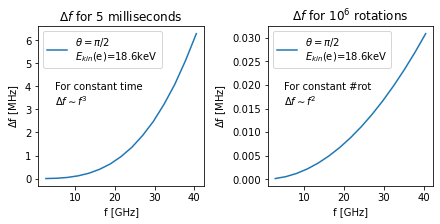

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(6,3), constrained_layout = True)

ax[0].plot(f_min,delta_f, label=r'$\theta=\pi/2$'+'\n'+r'$E_{kin}$(e)=18.6keV')
#plt.plot(f_min,np.array(f_min)**3/10500) # this fits perfectly
ax[0].set_xlabel('f [GHz]')
ax[0].set_ylabel(r'$\Delta$f [MHz]')
ax[0].set_title(r'$\Delta f$ for 5 milliseconds')
ax[0].legend()
ax[0].text(0.1,0.5,'For constant time\n'+r'$\Delta f \sim f^3$', transform=ax[0].transAxes)

ax[1].plot(f_min,delta_f_rot, label=r'$\theta=\pi/2$'+'\n'+r'$E_{kin}$(e)=18.6keV')
#plt.plot(f_min,np.array(f_min)**3/10500) # this fits perfectly
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'$\Delta$f [MHz]')
ax[1].set_title(r'$\Delta f$ for $10^6$ rotations')
ax[1].legend()
ax[1].text(0.1,0.5,'For constant #rot\n'+r'$\Delta f \sim f^2$', transform=ax[1].transAxes)

fig.savefig(out_dir+'bandwidth_dep.pdf')

# Important, you demonstrated that the difference in frequency over a given time of cyclotron motion behaves as the third power of the frequency. 
# This is expected since P~f**2 and df~fdE and therefore df ~ f**3 if time is constant. 
# The difference in frequency for a given number of rotations scales as the secodn power of the frequency. 
# This is expected since dt = rotations/f in combination with the previous statement. 